# CNN Classification task using PyTorch on MNIST dataset

## `1.` Import needed libraries

In [4]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from torchsummary import summary

## `2.` Load the data


In [5]:
data_transform = transforms.Compose([
            transforms.Resize((32,32)) ,
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))])

In [6]:
train_set = datasets.MNIST(root = './data' , train = True , download= True , transform= data_transform)
train_loader =DataLoader(train_set , batch_size= 64 , shuffle= True , drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 129774856.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 24646122.85it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 173413189.15it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4822918.68it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
test_set = datasets.MNIST(root = './data' , train = False , download= True , transform= data_transform)
test_loader =DataLoader(test_set , batch_size= 64 , shuffle= False , drop_last=True)

In [8]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Input shape: {data.shape}, Target shape: {target.shape}")
    break

Input shape: torch.Size([64, 1, 32, 32]), Target shape: torch.Size([64])


### plot samples of data

In [9]:
def plot_samples(samples):
  '''
  This function plots the first 9 samples form the passed dataset
  ----------------------------------
  parameters:
  samples : the dataset you want to plot samples from it

  '''
  plt.figure(figsize=(12,8))
  for i in range(9):
    plt.subplot(3, 3 , i+1)
    plt.imshow(samples[i].permute(1,2,0) , cmap = 'gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show();

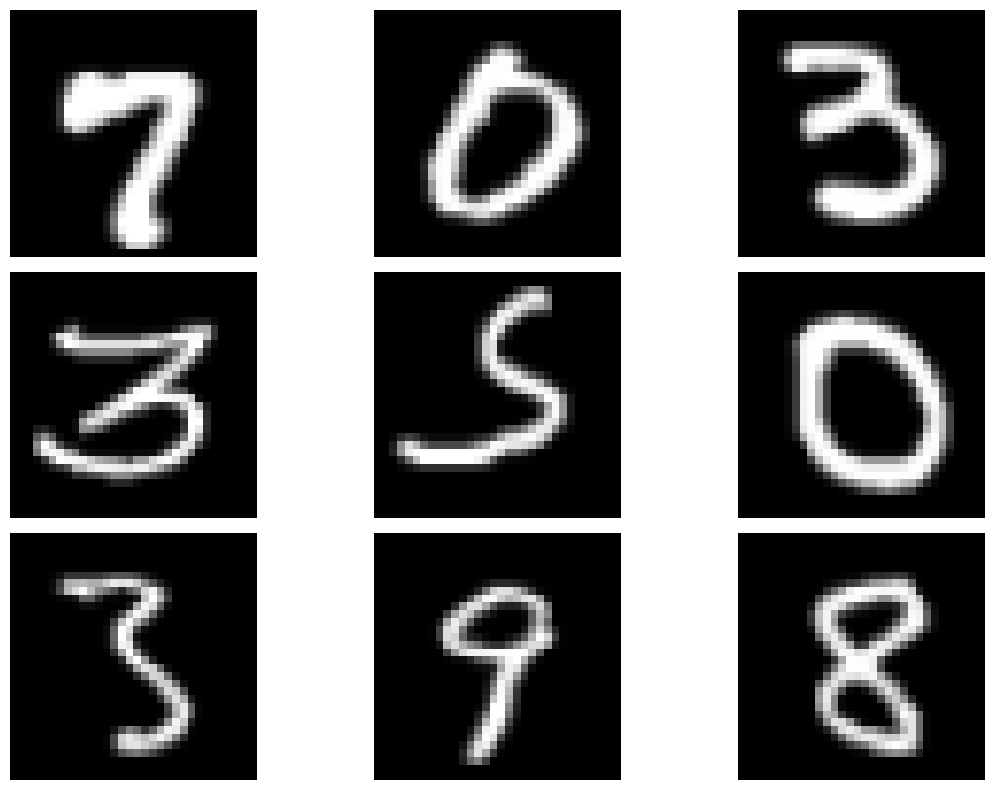

In [10]:
for batch in train_loader:
  images , labels = batch
  plot_samples(images)
  break

## `3.` Model building

### `Custom CNN architecture`

In [11]:
class Custom_CNN(nn.Module):
    def __init__(self, activation='relu', pooling='max', dropout_prob=0.0):
        super(Custom_CNN, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
        }
        self.pooling_fn = {
            'max': nn.MaxPool2d(kernel_size=2, stride=2),
            'avg': nn.AvgPool2d(kernel_size=2, stride=2)
        }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = self.pooling_fn[self.pooling]

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8* 8)
        x = self.fc1(x)
        x = self.activation_fn[self.activation](x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### `LeNet5 architecture `

In [12]:
class LeNet5(nn.Module):
    def __init__(self , activation = 'relu' , pooling = 'max' , dropout_prob = 0.0):
        super(LeNet5, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
            }
        self.pooling_fn = {
                'max': nn.MaxPool2d(kernel_size=2, stride=2),
                'avg': nn.AvgPool2d(kernel_size=2, stride=2)
            }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Average Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv1(x)))
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(self.activation_fn[self.activation](self.fc1(x)))
        x = self.dropout(self.activation_fn[self.activation](self.fc2(x)))
        x = self.fc3(x)
        return x

## `4.` Model training

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [24]:
cnn_model = Custom_CNN(activation= 'sigmoid', pooling = 'max' , dropout_prob= 0.5 ).to(device)
summary(cnn_model ,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


In [25]:
lenet_model = LeNet5(activation= 'sigmoid', pooling = 'max' , dropout_prob= 0.5).to(device)
summary(lenet_model , input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [26]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()

In [27]:
def model_train(model, device, train_loader,test_loader, optimizer, criterion, epochs):
    model.train()

    train_losses = []
    test_accuracies = []
    test_loss = 0
    test_losses = []

    optimizers = {
        'adam': torch.optim.Adam(model.parameters()),
        'SGD' : torch.optim.SGD(model.parameters()),
        'RMSProp' : torch.optim.RMSprop(model.parameters())}

    for epoch in range(epochs):
        train_loss = 0
        num_batches = len(train_loader)
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizers[optimizer].zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizers[optimizer].step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.item()}")
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        test_loss , accuracy = evaluate_model(model, device, test_loader)
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

    visualize_results(train_losses , test_accuracies , epochs)
    return train_losses, test_losses , test_accuracies

## `5.` Model evaluation

In [18]:
def evaluate_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

## `6.` Visualizing results

In [19]:
def visualize_results(losses, accuracies, epochs):
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()


# `i` Model process

In [20]:
torch.manual_seed(42)

## CNN trainnig:

In [28]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = cnn_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 2.267098903656006
Epoch 1, Batch 200, Loss: 2.3549582958221436
Epoch 1, Batch 300, Loss: 2.374218702316284
Epoch 1, Batch 400, Loss: 2.362375497817993
Epoch 1, Batch 500, Loss: 2.3124003410339355
Epoch 1, Batch 600, Loss: 2.3537096977233887
Epoch 1, Batch 700, Loss: 2.3355507850646973
Epoch 1, Batch 800, Loss: 2.3457934856414795
Epoch 1, Batch 900, Loss: 2.25032377243042
Epoch 1, Loss: 2.3170, Accuracy: 11.35%
Epoch 2, Batch 100, Loss: 2.3103842735290527
Epoch 2, Batch 200, Loss: 2.3110504150390625
Epoch 2, Batch 300, Loss: 2.298562526702881
Epoch 2, Batch 400, Loss: 2.310502767562866
Epoch 2, Batch 500, Loss: 2.3016610145568848
Epoch 2, Batch 600, Loss: 2.29677152633667
Epoch 2, Batch 700, Loss: 2.3025753498077393
Epoch 2, Batch 800, Loss: 2.3008952140808105
Epoch 2, Batch 900, Loss: 2.294322967529297
Epoch 2, Loss: 2.3047, Accuracy: 11.35%
Epoch 3, Batch 100, Loss: 2.297682523727417
Epoch 3, Batch 200, Loss: 2.299051284790039
Epoch 3, Batch 300, Loss: 2.3075

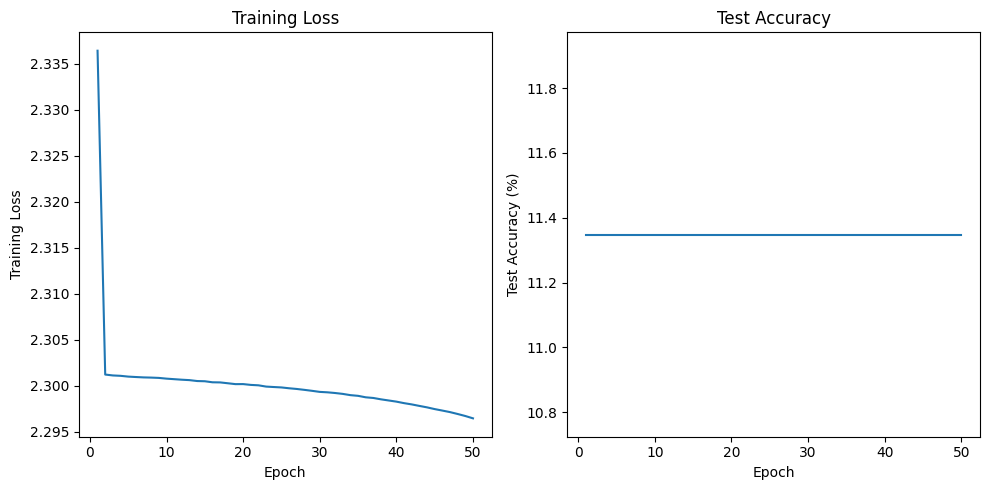

In [29]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'SGD', criterion, num_epochs)

## LeNet trainnig:

In [30]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = lenet_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 2.3919520378112793
Epoch 1, Batch 200, Loss: 2.336770534515381
Epoch 1, Batch 300, Loss: 2.321619749069214
Epoch 1, Batch 400, Loss: 2.4045727252960205
Epoch 1, Batch 500, Loss: 2.3462398052215576
Epoch 1, Batch 600, Loss: 2.425457000732422
Epoch 1, Batch 700, Loss: 2.362793445587158
Epoch 1, Batch 800, Loss: 2.330949544906616
Epoch 1, Batch 900, Loss: 2.35671067237854
Epoch 1, Loss: 2.3511, Accuracy: 10.29%
Epoch 2, Batch 100, Loss: 2.3033931255340576
Epoch 2, Batch 200, Loss: 2.3014235496520996
Epoch 2, Batch 300, Loss: 2.3021469116210938
Epoch 2, Batch 400, Loss: 2.2882347106933594
Epoch 2, Batch 500, Loss: 2.3013148307800293
Epoch 2, Batch 600, Loss: 2.3095715045928955
Epoch 2, Batch 700, Loss: 2.2964861392974854
Epoch 2, Batch 800, Loss: 2.3069605827331543
Epoch 2, Batch 900, Loss: 2.3000752925872803
Epoch 2, Loss: 2.3170, Accuracy: 11.35%
Epoch 3, Batch 100, Loss: 2.30250883102417
Epoch 3, Batch 200, Loss: 2.291646957397461
Epoch 3, Batch 300, Loss: 2.29

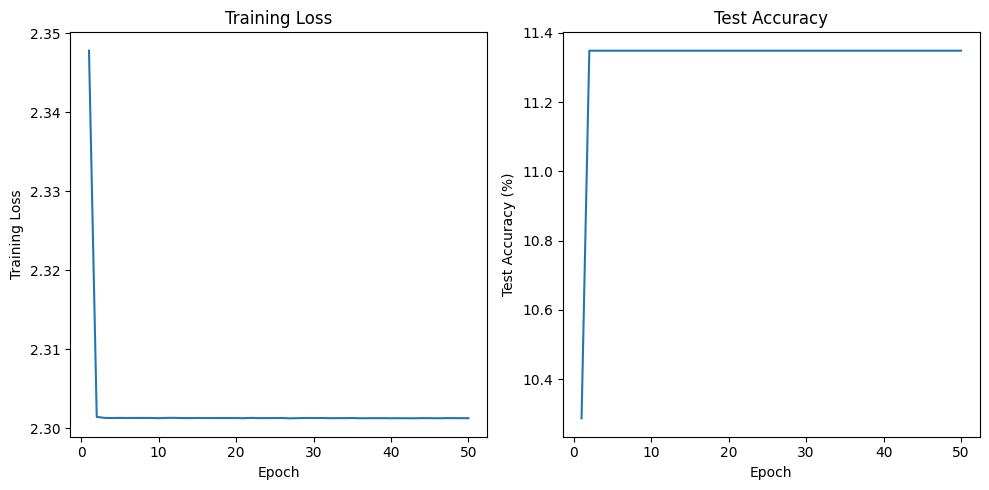

In [31]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'SGD', criterion, num_epochs)

## Trying different approaches:

In [33]:
cnn_model = Custom_CNN(activation= 'sigmoid' , pooling = 'avg' , dropout_prob = 0.2 ).to(device)
summary(cnn_model , (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         AvgPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         AvgPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 2.3095180988311768
Epoch 1, Batch 200, Loss: 2.2962076663970947
Epoch 1, Batch 300, Loss: 2.312390089035034
Epoch 1, Batch 400, Loss: 2.283323287963867
Epoch 1, Batch 500, Loss: 2.302663564682007
Epoch 1, Batch 600, Loss: 2.319143056869507
Epoch 1, Batch 700, Loss: 2.3144984245300293
Epoch 1, Batch 800, Loss: 2.29392147064209
Epoch 1, Batch 900, Loss: 2.2937698364257812
Epoch 1, Loss: 2.3192, Accuracy: 11.35%
Epoch 2, Batch 100, Loss: 2.3045003414154053
Epoch 2, Batch 200, Loss: 2.304443120956421
Epoch 2, Batch 300, Loss: 2.3153343200683594
Epoch 2, Batch 400, Loss: 2.305652141571045
Epoch 2, Batch 500, Loss: 2.296919822692871
Epoch 2, Batch 600, Loss: 2.2985570430755615
Epoch 2, Batch 700, Loss: 2.3086233139038086
Epoch 2, Batch 800, Loss: 2.2947003841400146
Epoch 2, Batch 900, Loss: 2.2958621978759766
Epoch 2, Loss: 2.2979, Accuracy: 11.35%
Epoch 3, Batch 100, Loss: 2.306108236312866
Epoch 3, Batch 200, Loss: 2.299013614654541
Epoch 3, Batch 300, Loss: 2.296

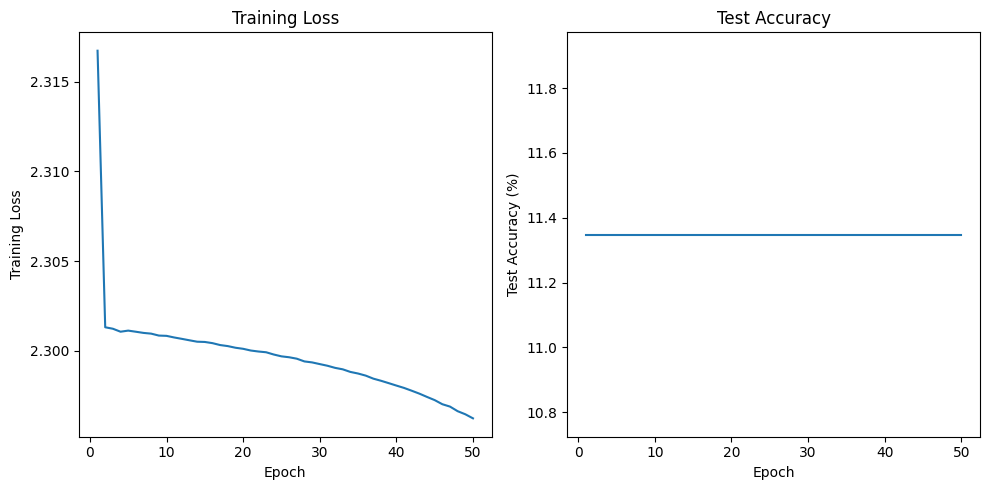

In [34]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'SGD', criterion, num_epochs)

In [36]:
lenet_model = LeNet5(activation= 'sigmoid' , pooling = 'avg' , dropout_prob = 0.2).to(device)
summary(lenet_model , (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 2.355132818222046
Epoch 1, Batch 200, Loss: 2.3335535526275635
Epoch 1, Batch 300, Loss: 2.301856756210327
Epoch 1, Batch 400, Loss: 2.302701234817505
Epoch 1, Batch 500, Loss: 2.3229832649230957
Epoch 1, Batch 600, Loss: 2.2966721057891846
Epoch 1, Batch 700, Loss: 2.2839274406433105
Epoch 1, Batch 800, Loss: 2.3199470043182373
Epoch 1, Batch 900, Loss: 2.329040050506592
Epoch 1, Loss: 2.3175, Accuracy: 11.35%
Epoch 2, Batch 100, Loss: 2.3093388080596924
Epoch 2, Batch 200, Loss: 2.2984511852264404
Epoch 2, Batch 300, Loss: 2.3012869358062744
Epoch 2, Batch 400, Loss: 2.2986021041870117
Epoch 2, Batch 500, Loss: 2.3030242919921875
Epoch 2, Batch 600, Loss: 2.303967237472534
Epoch 2, Batch 700, Loss: 2.2949411869049072
Epoch 2, Batch 800, Loss: 2.2965259552001953
Epoch 2, Batch 900, Loss: 2.3137924671173096
Epoch 2, Loss: 2.3068, Accuracy: 11.35%
Epoch 3, Batch 100, Loss: 2.2982983589172363
Epoch 3, Batch 200, Loss: 2.292755126953125
Epoch 3, Batch 300, Loss: 

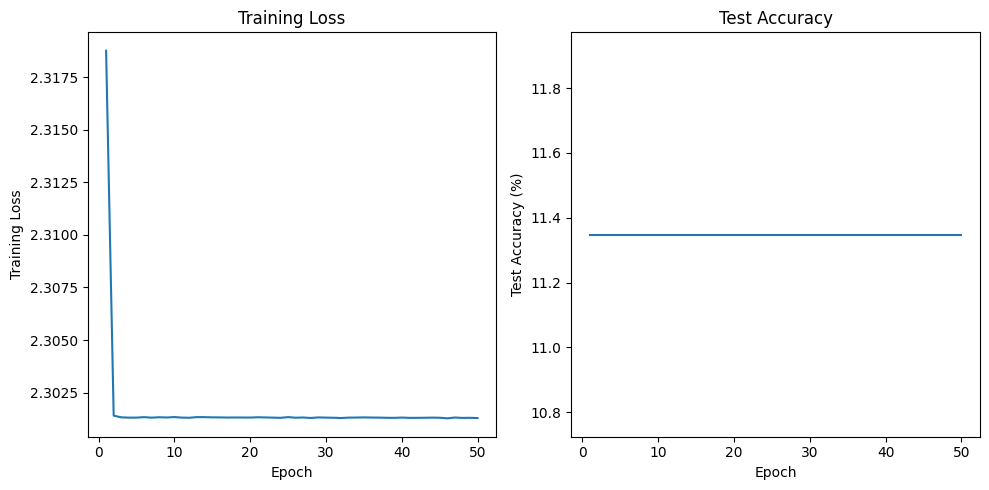

In [37]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'SGD', criterion, num_epochs)